# Interpretando o modelo

Para interpretar o modelo, utilizaremos o [SHAP](https://github.com/slundberg/shap).

### Config

In [25]:
import math
import pandas as pd
from sklearn.externals import joblib
import shap
import matplotlib.pyplot as plt

In [2]:
shap.initjs()

In [32]:
# exibe todas as colunas do DataFrame
pd.options.display.max_columns = 35

### Loading

In [4]:
lgbm = joblib.load('../models/lgbm.pkl')

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [6]:
X_train = train.drop(columns='Class')
X_test = test.drop(columns='Class')

y_train = train['Class']
y_test = test['Class']

In [7]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_daytime,Amount_1,Amount_99_99,Amount_0
0,113921,-0.132066,0.107044,-0.650588,-0.996032,1.814333,1.740740,0.496852,0.633016,0.017181,-0.362707,0.527911,0.505396,-0.742107,0.492430,-0.163585,-0.950404,0.262987,-1.760767,-0.939037,-0.062612,-0.062489,0.005292,0.251519,-2.466810,-0.889690,0.337462,0.306395,0.074817,47.89,0,False,False,False
1,135319,2.125994,0.014207,-1.514760,0.115021,0.598510,-0.333235,0.199289,-0.264353,0.384111,0.028747,-1.208334,0.838156,1.511476,-0.042076,-0.002894,0.080270,-0.658905,-0.747678,0.431762,-0.086076,-0.329368,-0.788150,0.267730,0.066122,-0.135785,0.203841,-0.068267,-0.057678,1.98,1,False,False,False
2,125498,-0.086694,0.166240,1.573127,0.687266,0.222359,1.102606,1.575093,-1.098608,0.763887,1.404677,1.346697,0.140822,0.159637,-1.147153,0.664997,-0.133032,-1.267675,0.818995,0.405276,0.052960,0.015324,1.063663,-0.410841,0.722723,-0.171733,-0.613543,-1.201571,-1.139931,170.10,1,False,False,False
3,33520,1.352339,-0.534984,0.555143,-0.629355,-1.144170,-0.852967,-0.642128,-0.032659,-0.654482,0.619206,0.103615,-1.067971,-1.227629,0.197196,1.151364,0.846905,0.710309,-1.963506,0.130406,-0.066712,-0.014814,-0.180379,0.178112,0.347720,0.151810,-0.404361,0.013746,0.016152,5.96,1,False,False,False
4,145152,-1.526760,0.647782,0.615391,-0.561114,0.836950,-0.514251,0.984325,-0.097430,-0.062634,-1.033567,-0.706095,-0.612354,-0.336939,-1.384147,0.314279,0.552201,0.512582,0.370183,-0.163736,-0.073333,-0.221533,-0.393158,-0.214990,0.588447,0.679496,0.518434,0.065022,0.147294,89.95,1,False,False,False


## Summary Plots

In [8]:
X_train_sample = X_train.sample(3_000, random_state=0)

In [9]:
explainer = shap.TreeExplainer(lgbm, data=X_train_sample)
shap_values = explainer.shap_values(X_train_sample)

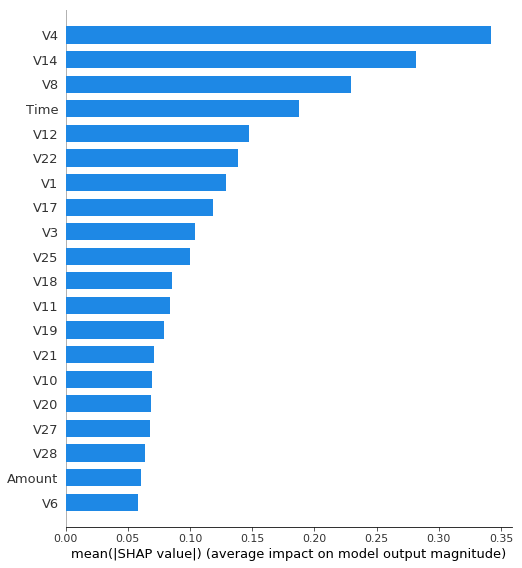

In [10]:
shap.summary_plot(shap_values, X_train_sample, plot_type='bar')

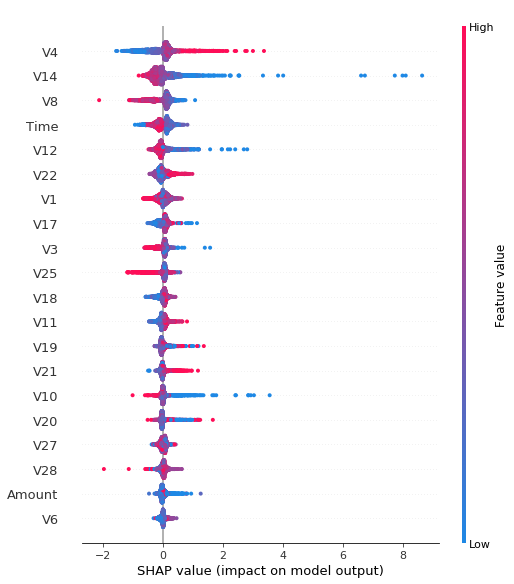

In [11]:
shap.summary_plot(shap_values, X_train_sample, plot_type='dot')

## Dependence Plots

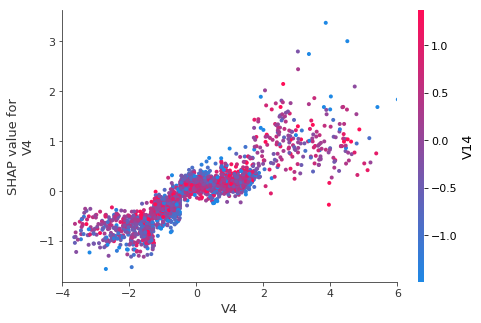

In [12]:
shap.dependence_plot('V4', shap_values, X_train_sample, show=False)
_ = plt.xlim(-4, 6)

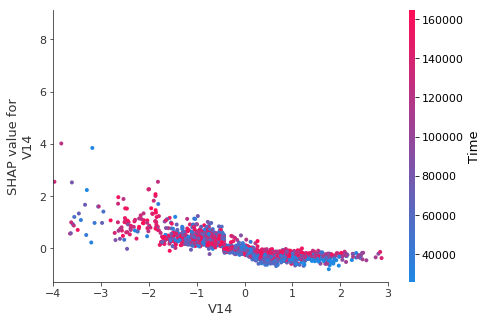

In [13]:
shap.dependence_plot('V14', shap_values, X_train_sample, show=False)
_ = plt.xlim(-4, 3)

## Force Plots

_Os plots abaixo podem não ser exibidos no GitHub ou em versões antigas do Jupyter._

In [53]:
threshold = 0.9423816758108632

In [58]:
def logistic(x):
    return 1 / (1 + math.exp(-x))

In [59]:
expected_value = explainer.expected_value
print(f'{logistic(expected_value):.5f}')

0.00007


In [50]:
y_score = lgbm.predict_proba(X_test)[:, 1]

In [51]:
results = pd.DataFrame(data=[y_score, y_test], 
                       index=['y_score', 'y_test'],
                       columns=y_test.index).T

In [52]:
results.head()

,y_score,y_test
0,0.00044,0.00000
1,0.00009,0.00000
2,0.00017,0.00000
3,0.00014,0.00000
4,0.00012,0.00000


In [62]:
def force_plot(id_):
    example = X_test.iloc[id_, :]
    shap_values_pred = explainer.shap_values(pd.DataFrame([example, example]))
    
    return shap.force_plot(expected_value,
                           shap_values_pred[0], 
                           example)

### False Positive Analysis

In [54]:
false_positives = (results['y_test'] == 0) & (results['y_score'] >= threshold)
false_positives_idx = test[false_positives].index

In [55]:
false_positives_df = (pd.concat([test.loc[false_positives_idx, :],
                                results[false_positives]],
                               axis='columns')
                        .sort_values(by='y_score', ascending=False))

false_positives_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_daytime,Amount_1,Amount_99_99,Amount_0,Class,y_score,y_test
15373,17044,-1.68695,4.08125,-7.77054,5.56524,-3.70160,-3.12492,-7.84861,1.74822,-3.27051,-11.20872,10.00219,-15.14499,-0.21378,-13.78038,-0.45942,-10.05311,...,1.29964,1.39314,-0.54361,-0.31786,-0.01553,1.17895,-0.20565,1.91197,0.95072,1.00000,0,True,False,False,0,0.99969,0.00000
42510,28233,-0.45979,2.86944,-5.41262,3.89374,-1.92008,-2.76000,-4.26011,0.87855,-2.63650,-7.13954,4.48889,-8.42917,-1.63269,-10.40937,1.08564,-5.57408,...,0.74340,0.78410,-0.55238,-0.28181,-0.05791,1.07777,-0.19886,1.16397,0.61042,1.00000,0,True,False,False,0,0.99945,0.00000
18326,27524,-26.61995,14.84554,-27.74708,6.40810,-19.02574,-5.05321,-19.04196,17.57371,-3.69586,-8.09805,4.52432,-6.31480,0.98325,-6.05213,-0.09991,-5.77246,...,1.84006,1.85321,-1.98557,-1.21012,0.15026,1.87926,-0.22502,1.25738,0.45178,1.00000,0,True,False,False,0,0.99917,0.00000
159,111638,-2.26146,0.22050,-3.55934,1.52241,-4.92053,0.84677,0.57208,0.86555,-1.06503,-4.02995,2.26133,-2.15107,0.19001,-2.76883,-0.89630,-3.09175,...,0.19283,0.46670,0.06096,1.36756,0.00131,-2.06869,-1.26680,1.01719,0.11685,798.49000,0,False,False,False,0,0.99090,0.00000
23112,26217,-17.95063,11.06707,-20.74266,6.07553,-13.38976,-4.53289,-15.18815,12.10106,-4.02688,-9.01741,6.07065,-8.56786,-0.00190,-9.30123,0.01980,-7.35212,...,1.71291,1.79713,-1.27567,-0.70505,0.10204,1.17748,-0.23873,1.55446,0.54795,1.00000,0,True,False,False,0,0.98296,0.00000
42431,157053,1.86144,1.00896,-2.01261,4.49172,1.02678,0.00848,-0.09569,0.18485,-0.17035,-0.36779,-0.93450,-1.74648,-1.90663,-4.21249,-1.29545,1.87557,...,-0.24736,-0.17606,-0.31455,0.03473,0.18221,0.09498,0.11734,0.02982,0.04789,11.32000,1,False,False,False,0,0.97922,0.00000
7214,166198,-35.54854,-31.85048,-48.32559,15.30418,-113.74331,73.30163,120.58949,-27.34736,-3.87242,-12.00549,6.85390,-9.18942,7.12688,-6.79594,8.87774,17.31511,...,-54.49772,-21.62012,5.71230,-1.58110,4.58455,4.55468,3.41564,31.61220,-15.43008,25691.16000,1,False,False,False,0,0.96876,0.00000


In [63]:
force_plot(false_positives_df.index[0])

In [64]:
force_plot(false_positives_df.index[1])

### False Negative Analysis

In [66]:
false_negatives = (results['y_test'] == 1) & (results['y_score'] < threshold)
false_negatives_idx = test[false_negatives].index

In [68]:
false_negatives_df = (pd.concat([test.loc[false_negatives_idx, :],
                                results[false_negatives]],
                               axis='columns')
                        .sort_values(by='y_score'))

false_negatives_df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Time_daytime,Amount_1,Amount_99_99,Amount_0,Class,y_score,y_test
3100,160791,2.13239,0.70561,-3.53076,0.51478,1.52717,-1.71627,1.13279,-0.57421,0.12890,-1.00081,-0.19119,-0.32379,-0.57246,-1.42206,0.31468,-0.38716,...,-0.21117,0.16374,0.70391,-0.24508,0.46005,0.92028,-0.21659,-0.02622,-0.02500,1.00000,1,True,False,False,1,0.00002,1.00000
81106,53076,1.29623,0.41745,0.19396,0.90164,0.13053,-0.37163,0.15813,-0.20267,-0.07951,-0.04509,-0.87674,0.68749,1.57472,-0.00779,0.94832,0.37715,...,-0.02956,-0.11211,-0.22000,-0.12102,-0.44045,0.67154,-0.41352,0.03284,0.02060,1.18000,1,False,False,False,1,0.00003,1.00000
16008,166831,-2.02714,-1.13189,-1.13519,1.08696,-0.01055,0.42380,3.79088,-1.15560,-0.06343,1.33441,1.03202,-0.72202,-1.53324,0.33412,0.29748,-0.42939,...,0.03380,-0.31510,0.57552,0.49084,0.75650,-0.14269,-0.60278,0.50871,-0.09165,634.30000,1,False,False,False,1,0.00004,1.00000
48825,84789,-1.43086,-0.80253,1.12332,0.38976,-0.28121,-0.05512,1.32623,0.19570,-0.54689,-0.71347,1.27463,0.02368,-1.52170,0.72724,0.16650,0.34804,...,0.63418,0.32558,0.01400,0.84495,0.11496,0.15636,-0.61944,-0.12035,0.03559,354.33000,1,False,False,False,1,0.00006,1.00000
59474,48533,1.24385,0.52453,-0.53888,1.20920,0.47954,-0.19743,0.04917,0.03779,0.12812,-0.55290,-0.66836,-0.81880,-0.88383,-0.99458,1.50685,0.62400,...,-0.17154,-0.05166,-0.08409,-0.19285,-0.91739,0.68195,-0.19442,0.04592,0.04014,1.00000,1,True,False,False,1,0.00008,1.00000
58930,65728,1.22761,-0.66897,-0.27178,-0.58944,-0.60480,-0.35028,-0.48636,-0.01081,-0.79494,0.26454,0.88127,-0.32470,-0.26326,-1.11274,-0.54085,1.53341,...,0.27380,-0.02605,-0.29525,-0.18046,-0.43654,0.49465,-0.28374,-0.00113,0.03507,98.01000,1,False,False,False,1,0.00009,1.00000
34368,68357,1.23260,-0.54893,1.08787,0.89408,-1.43305,-0.35680,-0.71749,0.00317,-0.10040,0.54319,-1.03942,0.28526,-0.20601,-0.49852,-1.06411,-2.15604,...,-0.57627,-0.44867,-0.51757,0.01283,0.69922,0.52726,-0.32261,0.08081,0.03543,19.59000,1,False,False,False,1,0.00011,1.00000
37076,67571,-0.75847,-0.04541,-0.16844,-1.31327,-1.90176,0.73943,3.07189,-0.48342,0.61820,-1.76906,-0.65141,-0.00542,-0.51719,0.21747,0.88356,-1.17398,...,-0.03250,0.04262,0.39722,0.07223,-0.24228,0.56092,-0.54095,0.15061,-0.11714,549.06000,1,False,False,False,1,0.00012,1.00000
74451,110087,1.93495,0.65068,-0.28696,3.98783,0.31605,-0.09945,-0.02148,-0.17233,0.50873,1.07296,-0.42757,-2.77765,1.63714,1.57108,-1.44537,0.90865,...,-0.34445,-0.17360,-0.19097,0.21998,-0.21660,-0.13669,-0.12995,-0.05008,-0.05108,1.00000,0,True,False,False,1,0.00015,1.00000
47582,132086,-0.36143,1.13347,-2.97136,-0.28307,0.37145,-0.57468,4.03151,-0.93440,-0.76825,-2.24812,-0.48241,-0.69055,0.18127,-2.37255,-0.00687,0.14640,...,-0.02586,0.11081,0.56386,-0.40844,-0.88008,1.40839,-0.13740,-0.00125,-0.18275,480.72000,1,False,False,False,1,0.00066,1.00000


In [69]:
force_plot(false_negatives_df.index[0])

In [70]:
force_plot(false_negatives_df.index[1])